In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1199_BNG_echoMonths', return_X_y=True)

In [5]:
X.shape

(17496, 9)

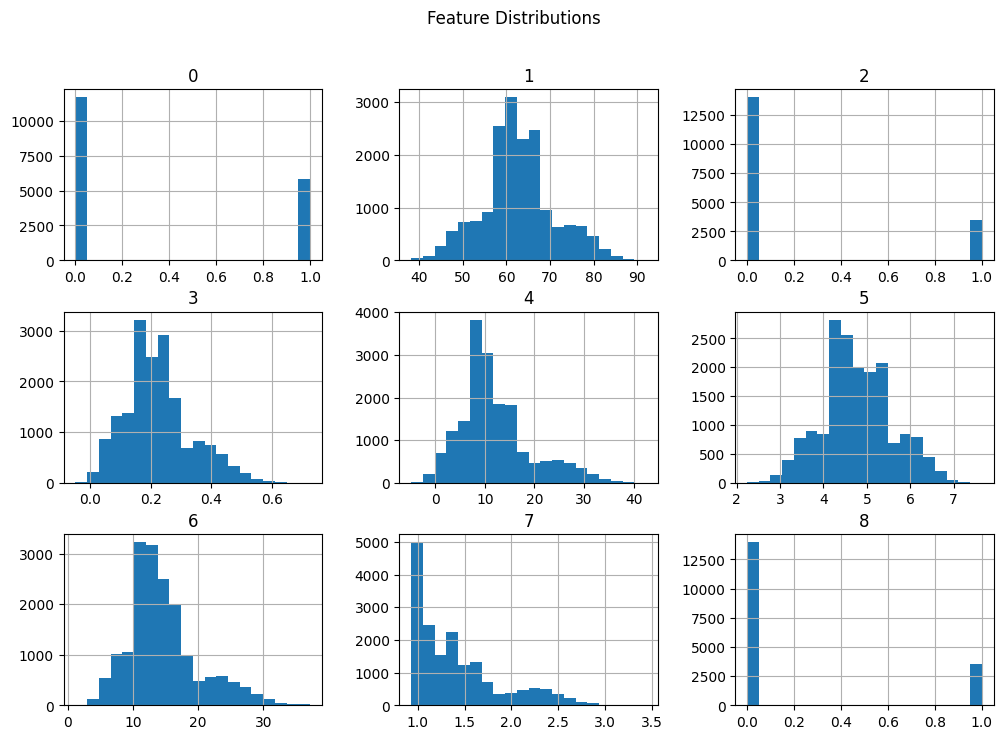

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

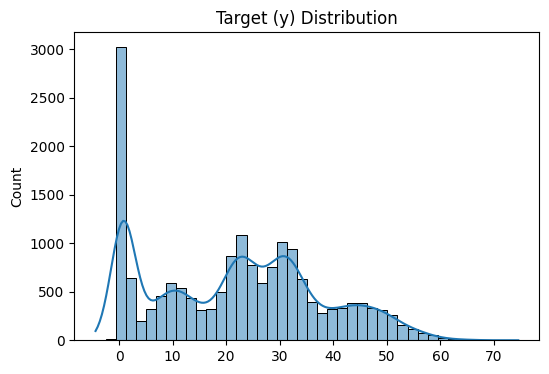

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

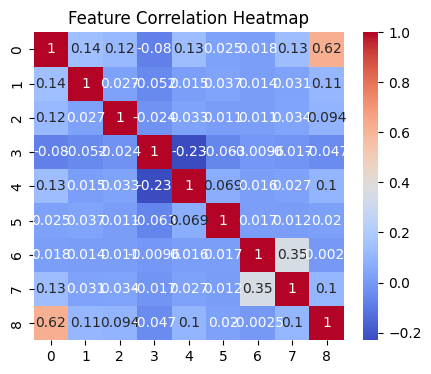

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.021784                 1.020444             1.175825   
1                  1.018753                 1.031950             1.103535   
2                  1.010191                 1.059626             1.185627   
3                  1.024177                 1.009793             1.137833   
4                  1.053926                 1.035916             1.241912   
mean               1.025766                 1.031546             1.168946   
std                0.016607                 0.018736             0.052192   

      DefaultBART_Rhat_RMSE  
0                  1.821093  
1                  1.261651  
2                  1.579073  
3                  1.497756  
4                  1.461622  
mean               1.524239  
std                0.202918  


In [10]:
rhat_df.to_csv("results/real6_echoMonths_rhat.csv", index=False)

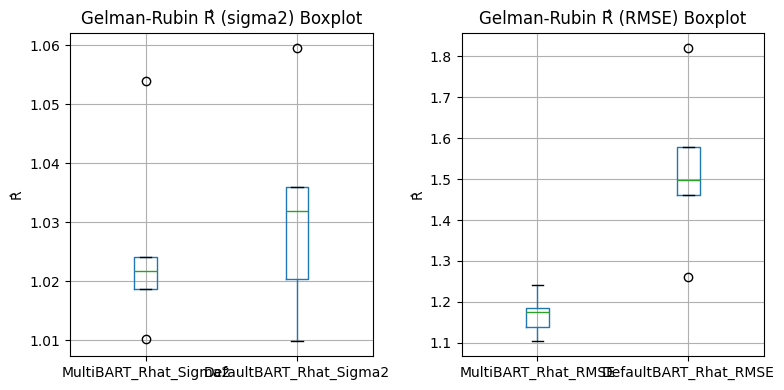

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
       bart_mtmh        bart         btz          rf         xgb
0     127.806322  128.654529  128.896567  132.644593  139.323217
1     131.493640  132.838461  132.698416  135.221860  142.761038
2     127.883339  129.250916  129.785157  134.094306  139.665325
3     130.894537  130.224449  130.865298  136.009708  142.592322
4     129.766402  132.241688  131.089606  134.661939  142.401405
5     131.304003  133.821321  133.905440  137.830949  144.409112
6     127.428112  129.641665  129.154672  130.075645  143.240277
7     133.042474  133.891249  135.338529  137.396965  146.489538
8     129.244891  131.136033  132.440428  134.223581  144.326072
9     125.822855  126.826826  126.890078  129.732321  139.346478
mean  129.468657  130.852714  131.106419  134.189187  142.455479
std     2.239677    2.344377    2.545885    2.735311    2.394027



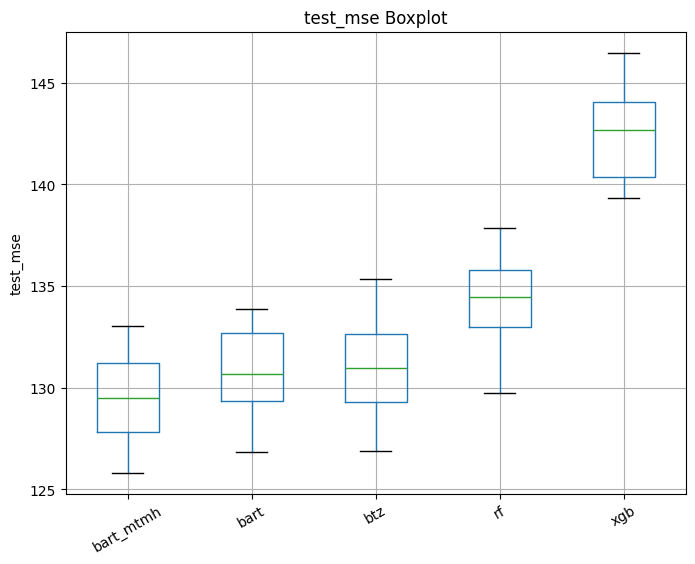

train_mse:
       bart_mtmh        bart         btz         rf        xgb
0     115.519253  123.448662  125.820258  18.837764  60.015500
1     114.661515  122.119894  126.047821  18.643544  56.621137
2     117.039771  124.201684  125.360341  18.682658  60.429968
3     114.604623  123.494982  125.596900  18.630229  59.054943
4     115.533355  123.258623  126.416403  18.653725  59.621118
5     113.897135  122.570368  124.980261  18.613275  59.194286
6     115.768659  124.240639  126.255678  18.792801  60.125988
7     114.383996  121.879313  124.796219  18.492577  59.351145
8     115.539855  123.792282  126.338806  18.767559  57.660885
9     115.069199  124.094953  127.658212  18.807122  58.739761
mean  115.201736  123.310140  125.927090  18.692126  59.081473
std     0.885784    0.854810    0.826322   0.107524   1.171292



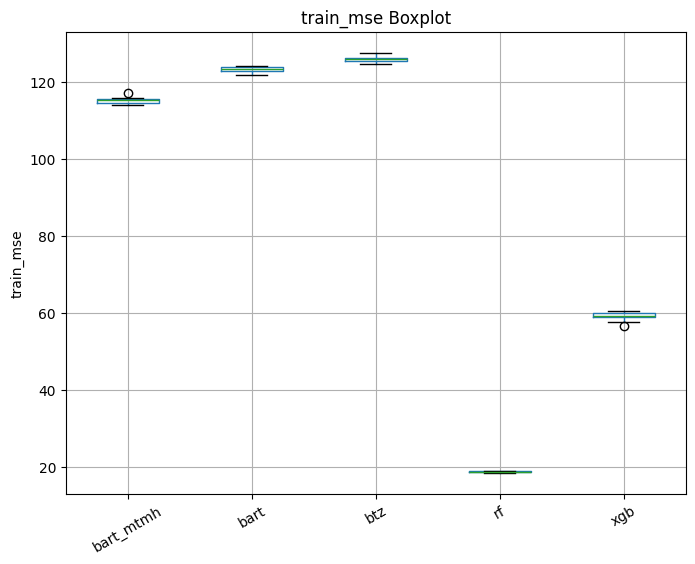

pi_length:
      bart_mtmh       bart        btz
0     43.809919  44.077663  44.771961
1     43.676568  43.980476  44.843945
2     44.005376  44.302950  44.636318
3     43.689552  44.188378  44.809223
4     43.695866  44.094613  44.708122
5     43.483251  44.148527  44.628208
6     43.945908  44.275508  44.754211
7     43.616880  43.914252  44.620079
8     43.775538  44.191054  44.812149
9     43.831600  44.353938  45.203686
mean  43.753046  44.152736  44.778790
std    0.154653   0.140015   0.170172



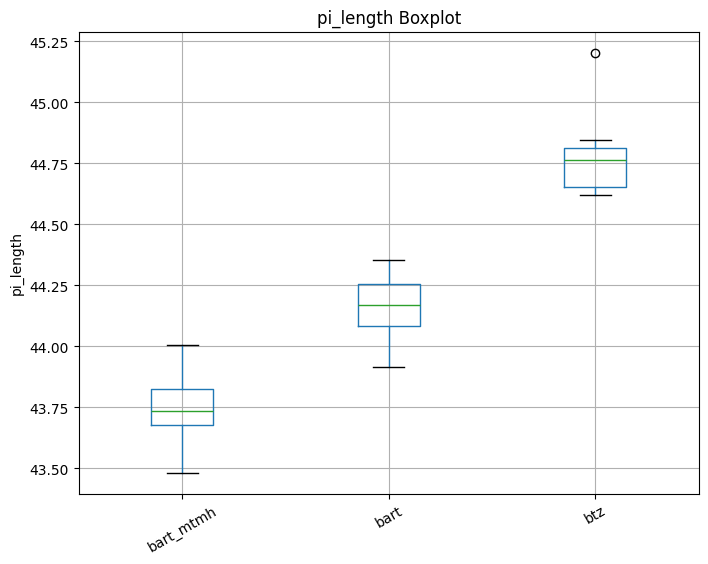

coverage:
      bart_mtmh      bart       btz
0      0.936214  0.938043  0.940558
1      0.933242  0.936443  0.940558
2      0.936214  0.941015  0.938500
3      0.933928  0.940786  0.944444
4      0.938272  0.938043  0.942158
5      0.934614  0.935757  0.939415
6      0.940786  0.947417  0.944216
7      0.935985  0.940101  0.942158
8      0.932327  0.936900  0.941015
9      0.938957  0.944216  0.950846
mean   0.936054  0.939872  0.942387
std    0.002671  0.003685  0.003524



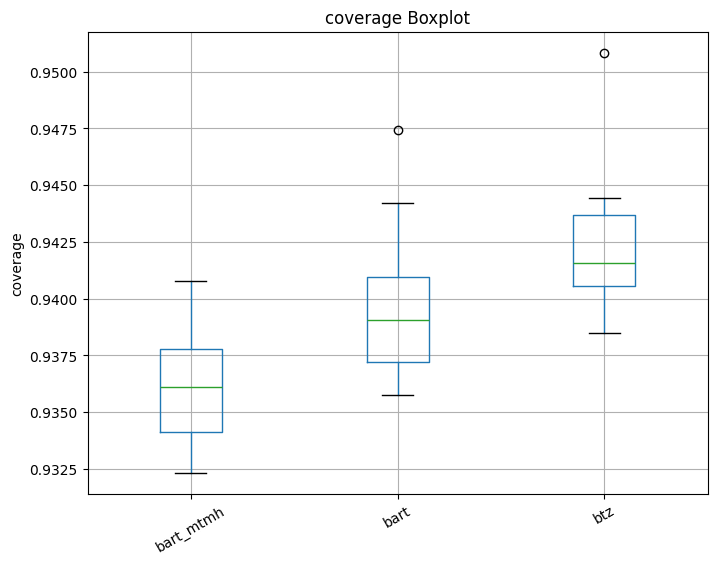

train_time:
       bart_mtmh       bart        btz         rf       xgb
0     467.692874  61.139063  40.662139  12.056580  0.309150
1     475.448461  66.791520  41.274893   8.622535  0.303247
2     471.152309  63.204775  41.739570   9.867212  0.246871
3     456.608393  60.131629  38.724172  14.148425  0.439170
4     472.198703  62.619813  41.739221   9.786999  0.259519
5     480.320981  60.098725  43.243975  12.293402  0.255084
6     476.443221  62.075284  42.549282  13.184741  0.298977
7     481.512492  62.228930  44.376293  10.878191  0.277421
8     483.959416  65.317040  44.586164   8.657323  0.248052
9     479.641248  64.857543  44.647254   8.415754  0.261857
mean  474.497810  62.846432  42.354296  10.791116  0.289935
std     8.073255   2.228679   1.918316   2.044690  0.057342



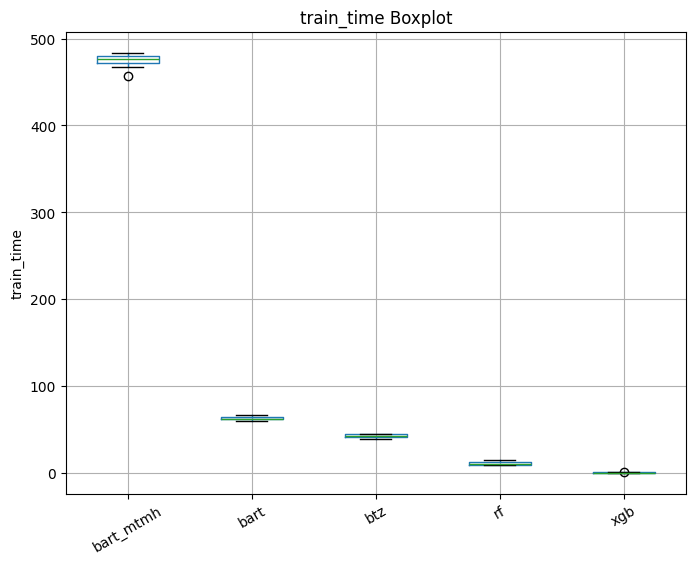

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real6_echoMonths_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [14]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real6_echoMonths_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1,5,10,50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real6_echoMonths_tries.csv", index=False)

In [15]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE    Test_MSE  Coverage   Train_Time
0            1     1.057682   1.423698  131.057381  0.936854    94.418368
1            5     1.054200   1.191430  129.616769  0.936991   278.651683
2           10     1.025766   1.168946  129.425764  0.935665   513.070776
3           50     1.029837   1.134988  129.603564  0.934522  2404.522043
